# House Price Prediction in Ames, Iowa, USA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Markdown formats: All tables and images will be aligned to the left.*

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

## Preparation

*Load some standard Python libraries.*

In [ ]:
from __future__ import print_function
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

*Load Keras libraries used in this example.*

In [ ]:
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

*Sklearn and its Tensorflow wrappers (not all used)*

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Utilities and Settings

*Plotting history*

In [ ]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

*Options to control Pandas display*

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Ames real-estate data

*Load data from CSV file and define the label column.*

In [ ]:
ames_data_org = pd.read_csv("/content/drive/My Drive/ames_house_data.csv")
ames_data_org.set_index('PID', inplace=True)
ames_data_org.head(10)
print('Number of records read: ', len(ames_data_org))

Number of records read:  2930


In [ ]:
# Finding column types
ames_data_org.dtypes

Order                int64
MS_SubClass          int64
MS_Zoning           object
Lot_Frontage       float64
Lot_Area             int64
Street              object
Alley               object
Lot_Shape           object
Land_Contour        object
Utilities           object
Lot_Config          object
Land_Slope          object
Neighborhood        object
Condition_1         object
Condition_2         object
Bldg_Type           object
House_Style         object
Overall_Qual         int64
Overall_Cond         int64
Year_Built           int64
Year_Remod/Add       int64
Roof_Style          object
Roof_Matl           object
Exterior_1st        object
Exterior_2nd        object
Mas_Vnr_Type        object
Mas_Vnr_Area       float64
Exter_Qual          object
Exter_Cond          object
Foundation          object
Bsmt_Qual           object
Bsmt_Cond           object
Bsmt_Exposure       object
BsmtFin_Type_1      object
BsmtFin_SF_1       float64
BsmtFin_Type_2      object
BsmtFin_SF_2       float64
B

# Categorical Variables

In [ ]:
# Identification of missing values
missing = ames_data_org.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False)

Pool_QC           2917
Misc_Feature      2824
Alley             2732
Fence             2358
Fireplace_Qu      1422
Lot_Frontage       490
Garage_Yr_Blt      159
Garage_Cond        159
Garage_Qual        159
Garage_Finish      159
Garage_Type        157
Bsmt_Exposure       83
BsmtFin_Type_2      81
Bsmt_Cond           80
Bsmt_Qual           80
BsmtFin_Type_1      80
Mas_Vnr_Type        23
Mas_Vnr_Area        23
Bsmt_Half_Bath       2
Bsmt_Full_Bath       2
Garage_Cars          1
BsmtFin_SF_2         1
BsmtFin_SF_1         1
Bsmt_Unf_SF          1
Total_Bsmt_SF        1
Garage_Area          1
Electrical           1
dtype: int64

*Dropping columns with lots of missing values then show statistics about each column.*

In [ ]:
ames_data_org.drop(['Pool_QC', 'Misc_Feature', 'Alley', 'Fence', 'Fireplace_Qu'], axis=1, inplace=True)
ames_data_org.describe(include='all')

,Order,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
count,2930.00000,2930.000000,2930,2440.000000,2930.000000,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930.000000,2930.000000,2930.000000,2930.000000,2930,2930,2930,2930,2907,2907.000000,2930,2930,2930,2850,2850,2847,2850,2929.000000,2849,2929.000000,2929.000000,2929.000000,2930,2930,2930,2929,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930,2930.000000,2930,2930.000000,2773,2771.000000,2771,2929.000000,2929.000000,2771,2771,2930,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930,2930,2930.000000
unique,NaN,NaN,7,NaN,NaN,2,4,4,3,5,3,28,9,8,5,8,NaN,NaN,NaN,NaN,6,8,16,17,5,NaN,4,5,6,5,5,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,8,NaN,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,GLQ,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,2273,NaN,NaN,2918,1859,2633,2927,2140,2789,443,2522,2900,2425,1481,NaN,NaN,NaN,NaN,2321,2887,1026,1015,1752,NaN,1799,2549,1310,1283,2616,1906,859,NaN,2499,NaN,NaN,NaN,2885,1495,2734,2682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1494,NaN,2728,NaN,1731,NaN,1231,NaN,NaN,2615,2665,2652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2536,2413,NaN
mean,1465.50000,57.387372,NaN,69.224590,10147.921843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.094881,5.563140,1971.356314,1984.266553,NaN,NaN,NaN,NaN,NaN,101.896801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.629566,NaN,49.722431,559.262547,1051.614544,NaN,NaN,NaN,NaN,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,NaN,6.443003,NaN,0.599317,NaN,1978.132443,NaN,1.766815,472.819734,NaN,NaN,NaN,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,NaN,NaN,180796.060068
std,845.96247,42.638025,NaN,23.365335,7880.017759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.411026,1.111537,30.245361,20.860286,NaN,NaN,NaN,NaN,NaN,179.112611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.590839,NaN,169.168476,439.494153,440.615067,NaN,NaN,NaN,NaN,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,NaN,1.572964,NaN,0.647921,NaN,25.528411,NaN,0.760566,215.046549,NaN,NaN,NaN,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,NaN,NaN,79886.692357
min,1.00000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,1895.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000

*Selecting numeric columns and a few "promising" one-hot-encoded categorical variables.<br>

In [ ]:
ames_data_num = ames_data_org.select_dtypes(include='number')
ames_data_hstyle= pd.get_dummies(ames_data_org['House_Style'], prefix='HStyle')
ames_data_area  = pd.get_dummies(ames_data_org['Neighborhood'], prefix='Area')
ames_data_roof  = pd.get_dummies(ames_data_org['Roof_Style'], prefix='roof')
ames_data_heat  = pd.get_dummies(ames_data_org['Heating'], prefix='heat')
ames_data_foundation  = pd.get_dummies(ames_data_org['Foundation'], prefix='Foundations') 
ames_data_garage  = pd.get_dummies(ames_data_org['Garage_Type'], prefix='garage')
ames_data_kitchen_qual  = pd.get_dummies(ames_data_org['Kitchen_Qual'], prefix='kitchen_qual')

ames_data = pd.concat([ames_data_num, ames_data_hstyle, ames_data_area, ames_data_roof, 
                       ames_data_heat, ames_data_garage,ames_data_kitchen_qual, ames_data_foundation], axis=1, join='inner')

label_col = 'SalePrice'
ames_data.head(10)

,Order,MS_SubClass,Lot_Frontage,Lot_Area,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Yr_Blt,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,SalePrice,HStyle_1.5Fin,HStyle_1.5Unf,HStyle_1Story,HStyle_2.5Fin,HStyle_2.5Unf,HStyle_2Story,HStyle_SFoyer,HStyle_SLvl,Area_Blmngtn,Area_Blueste,Area_BrDale,Area_BrkSide,Area_ClearCr,Area_CollgCr,Area_Crawfor,Area_Edwards,Area_Gilbert,Area_Greens,Area_GrnHill,Area_IDOTRR,Area_Landmrk,Area_MeadowV,Area_Mitchel,Area_NAmes,Area_NPkVill,Area_NWAmes,Area_NoRidge,Area_NridgHt,Area_OldTown,Area_SWISU,Area_Sawyer,Area_SawyerW,Area_Somerst,Area_StoneBr,Area_Timber,Area_Veenker,roof_Flat,roof_Gable,roof_Gambrel,roof_Hip,roof_Mansard,roof_Shed,heat_Floor,heat_GasA,heat_GasW,heat_Grav,heat_OthW,heat_Wall,garage_2Types,garage_Attchd,garage_Basment,garage_BuiltIn,garage_CarPort,garage_Detchd,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_Po,kitchen_qual_TA,Foundations_BrkTil,Foundations_CBlock,Foundations_PConc,Foundations_Slab,Foundations_Stone,Foundations_Wood
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
526301100,1,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
526350040,2,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
526351010,3,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
526353030,4,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
527105010,5,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
527105030,6,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010,195500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
527127150,7,120,41.0,4920,8,5,2001,2001,0.0,616.0,0.0,722.0,1338.0,1338,0,0,1338,1.0,0.0,2,0,2,1,6,0,2001.0,2.0,582.0,0,0,170,0,0,0,0,4,2010,213500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
527145080,8,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010,191500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
527146030,9,120,39.0,5389,8,5,1995,1996,0.0,1180.0,0.0,415.0,1595.0,1616,0,0,1616,1.0,0.0,2,0,2,1,5,1,1995.0,2.0,608.0,237,152,0,0,0,0,0,3,2010,236500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## Split data for training and validation

*Split index ranges into three parts, however, ignore the third.*

In [ ]:
train_size, valid_size, test_size = (0.7, 0.3, 0.0)
ames_train, ames_valid = train_test_split(ames_data, 
                                      test_size=valid_size, 
                                      random_state=2020)

*Extract data for training and validation into x and y vectors.*

In [ ]:
ames_y_train = ames_train[[label_col]]
ames_x_train = ames_train.drop(label_col, axis=1)
ames_y_valid = ames_valid[[label_col]]
ames_x_valid = ames_valid.drop(label_col, axis=1)

print('Size of training set: ', len(ames_x_train))
print('Size of validation set: ', len(ames_x_valid))

Size of training set:  2051
Size of validation set:  879


## Prepare data for training and validation of the Keras model

*Creating an imputation model using training set and use it to impute both trainnig and validation data.*

In [ ]:
print('Missing trainnig values before imputation = ', ames_x_train.isnull().sum().sum())
print('Missing validation values before imputation = ', ames_x_valid.isnull().sum().sum())

imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(ames_x_train)
ames_x_train = pd.DataFrame(imputer.transform(ames_x_train), 
                            columns = ames_x_train.columns, index = ames_x_train.index)
ames_x_valid = pd.DataFrame(imputer.transform(ames_x_valid), 
                            columns = ames_x_valid.columns, index = ames_x_valid.index)

print('Missing trainnig values after imputation = ', ames_x_train.isnull().sum().sum())
print('Missing validation values after imputation = ', ames_x_valid.isnull().sum().sum())

Missing trainnig values before imputation =  472
Missing validation values before imputation =  210
Missing trainnig values after imputation =  0
Missing validation values after imputation =  0


*Creating a scaling model using training set and use it to scale both training and validation data.*

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(ames_x_train)
ames_x_train = pd.DataFrame(scaler.transform(ames_x_train), 
                            columns = ames_x_train.columns, index = ames_x_train.index)
ames_x_valid = pd.DataFrame(scaler.transform(ames_x_valid), 
                            columns = ames_x_valid.columns, index = ames_x_valid.index).clip(0, 1)

print('X train min =', round(ames_x_train.min().min(),4), '; max =', round(ames_x_train.max().max(), 4))
print('X valid min =', round(ames_x_valid.min().min(),4), '; max =', round(ames_x_valid.max().max(), 4))

X train min = 0.0 ; max = 1.0
X valid min = 0.0 ; max = 1.0


In [ ]:
ames_x_valid.head(10)

,Order,MS_SubClass,Lot_Frontage,Lot_Area,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Yr_Blt,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,HStyle_1.5Fin,HStyle_1.5Unf,HStyle_1Story,HStyle_2.5Fin,HStyle_2.5Unf,HStyle_2Story,HStyle_SFoyer,HStyle_SLvl,Area_Blmngtn,Area_Blueste,Area_BrDale,Area_BrkSide,Area_ClearCr,Area_CollgCr,Area_Crawfor,Area_Edwards,Area_Gilbert,Area_Greens,Area_GrnHill,Area_IDOTRR,Area_Landmrk,Area_MeadowV,Area_Mitchel,Area_NAmes,Area_NPkVill,Area_NWAmes,Area_NoRidge,Area_NridgHt,Area_OldTown,Area_SWISU,Area_Sawyer,Area_SawyerW,Area_Somerst,Area_StoneBr,Area_Timber,Area_Veenker,roof_Flat,roof_Gable,roof_Gambrel,roof_Hip,roof_Mansard,roof_Shed,heat_Floor,heat_GasA,heat_GasW,heat_Grav,heat_OthW,heat_Wall,garage_2Types,garage_Attchd,garage_Basment,garage_BuiltIn,garage_CarPort,garage_Detchd,kitchen_qual_Ex,kitchen_qual_Fa,kitchen_qual_Gd,kitchen_qual_Po,kitchen_qual_TA,Foundations_BrkTil,Foundations_CBlock,Foundations_PConc,Foundations_Slab,Foundations_Stone,Foundations_Wood
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
534450180,0.044042,0.000000,0.099315,0.027610,0.444444,0.75,0.623188,0.966667,0.000000,0.123317,0.000000,0.075244,0.140426,0.112500,0.000000,0.0,0.086151,0.333333,0.0,0.25,0.0,0.333333,0.333333,0.111111,0.00,0.266777,0.00,0.000000,0.082163,0.000000,0.0,0.0,0.000000,0.0,0.0,0.090909,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
905101310,0.074087,0.411765,0.174658,0.044301,0.333333,0.50,0.695652,0.300000,0.000000,0.000000,0.000000,0.821180,0.289362,0.323148,0.000000,0.0,0.259981,0.000000,0.0,0.50,0.0,0.666667,0.666667,0.555556,0.00,0.266777,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.272727,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
533127080,0.853875,0.235294,0.166376,0.061890,0.777778,0.75,0.876812,0.716667,0.000000,0.179305,0.000000,0.151417,0.218985,0.226852,0.565617,0.0,0.403629,0.333333,0.0,0.50,0.5,0.833333,0.333333,0.777778,0.25,0.314103,0.75,0.534946,0.146770,0.074124,0.0,0.0,0.000000,0.0,0.0,0.909091,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
908276150,0.307614,0.000000,0.166376,0.035645,0.333333,0.25,0.608696,0.100000,0.000000,0.000000,0.000000,0.312123,0.109984,0.136111,0.000000,0.0,0.105635,0.000000,0.0,0.25,0.0,0.500000,0.333333,0.222222,0.00,0.195513,0.25,0.193548,0.044944,0.000000,0.0,0.0,0.277778,0.0,0.0,0.818182,0.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
902330040,0.245476,0.294118,0.342466,0.076520,0.777778,1.00,0.072464,0.600000,0.000000,0.038271,0.000000,0.325128,0.149918,0.125926,0.400000,0.0,0.255014,0.000000,0.0,0.25,0.5,0.666667,0.333333,0.555556,0.25,0.096154,0.50,0.284946,0.000000,0.227763,0.0,0.0,0.000000,0.0,0.0,0.909091,0.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

*Converting pandas data frames to np arrays.*

In [ ]:
arr_x_train = np.array(ames_x_train)
arr_y_train = np.array(ames_y_train)
arr_x_valid = np.array(ames_x_valid)
arr_y_valid = np.array(ames_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (2051, 102)
Training samples:  2051
Validation samples:  879


# Settings for Keras modelling

*Defining parameters for various models.*

In [ ]:
epochs = 500
batch_size = 64
learningrate = 0.001
decay = 0.0
rho = 0.9
momentum = 0.0
nadam_b1 = 0.9
nadam_b2 = 0.999
epsilon = 1e-07

*Specify Keras callbacks which allow additional functionality while the model is being fitted.*
- ***ModelCheckpoint*** *allows to save the models as they are being built or improved.*
- ***TensorBoard*** *interacts with TensorFlow interactive reporting system.*
- ***EarlyStopping*** *watches one of the model measurements and stops fitting when no improvement.*

In [ ]:
log_dir = os.path.join(
    os.getcwd(),
    os.pardir,
    "Logs",
    "fit2",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)

print(log_dir)

keras_callbacks = [
    # ModelCheckpoint('../Models/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('../Models/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, 
    #            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
    #            profile_batch = 100000000),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

/content/../Logs/fit2/20201007-084910


## Create Keras model

***Three functions to define alternative Keras models***

*The first is very simple, consisting of three layers and Adam optimizer.*

# Basic Model 1,2 and 3

In [ ]:
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=RMSprop(lr=learningrate, rho=rho, epsilon=epsilon, decay=decay),
        metrics=[metrics.mae])
    return(t_model)

*The second with RMSProp optimizer consists of 4 layers and the first uses 20% dropouts.*

In [ ]:
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(180, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=RMSprop(lr=learningrate, rho=rho, momentum=momentum, decay=decay, epsilon=epsilon),
        metrics=[metrics.mae])
    return(t_model)

*The third is the most complex, it extends the previous model with Nadam optimizer, dropouts and L1/L2 regularisers.*

In [ ]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=Nadam(learning_rate=learningrate, beta_1=nadam_b1, beta_2=nadam_b2, epsilon=epsilon),
        metrics=[metrics.mae])
    return(t_model)

We will experiment with the above models and find out the best one.

# ALL OPTIMIZERS

In [ ]:
opt_sgd_1 = SGD(lr=0.01, momentum=0.0, nesterov=False) # Is not working with this Dataset
opt_sgd_2 = SGD(lr=0.05, momentum=0.1, nesterov=False) # Is not working with this Dataset
opt_rmsprop_1 = RMSprop(lr=0.005, rho=0.9, decay=0.5, epsilon=1e-07)
opt_rmsprop_2 = RMSprop(lr=0.01, rho=0.9, decay=0.1, epsilon=1e-07)
opt_adadelta_1 = Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)
opt_adadelta_2 = Adadelta(lr=0.01, rho=0.99, epsilon=1e-07)
opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
opt_adam_2 = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)
opt_nadam = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

# Basic Model 4  +  Heating + Roof Style

In [ ]:
# Parameters

epochs = 500
batch_size = 64
learningrate = 0.001
decay = 0.0
rho = 0.9
momentum = 0.0
nadam_b1 = 0.9
nadam_b2 = 0.999
epsilon = 1e-07

# Optimizer applied
opt_nadam = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)

def basic_model_4(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_nadam,
        metrics=[metrics.mae])
    return(t_model)

# Train MAE: 13,170
# Val   MAE: 15,354

# Early Stopping   : 390

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  13169.9346 , Train Loss:  402512064.0
Val Mean: 180034.4972
Val MAE:  15354.8916 , Val Loss:  638365888.0


## Plotting

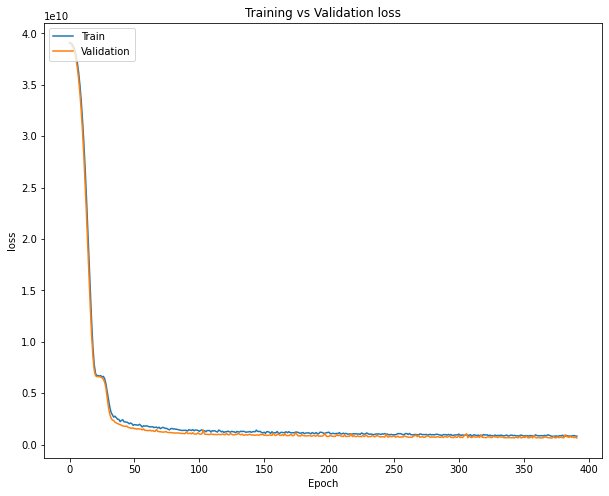

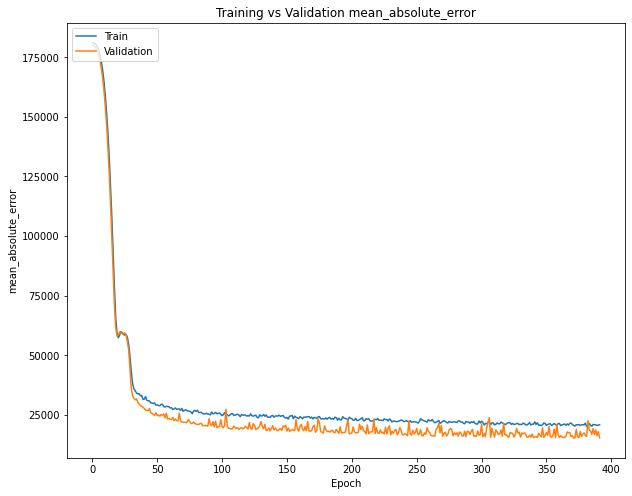

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 5

In [ ]:
# Parameters

epochs = 500
batch_size = 64
learningrate = 0.001
decay = 0.0
rho = 0.9
momentum = 0.0
nadam_b1 = 0.9
nadam_b2 = 0.999
epsilon = 1e-07

# Optimizer applied

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

def basic_model_5(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_1,
        metrics=[metrics.mae])
    return(t_model)

# Train MAE: 13,638
# Val   MAE: 15,661

# Early Stopping   : 179

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  13638.6914 , Train Loss:  487569504.0
Val Mean: 180034.4972
Val MAE:  15661.874 , Val Loss:  731811904.0


## Plotting

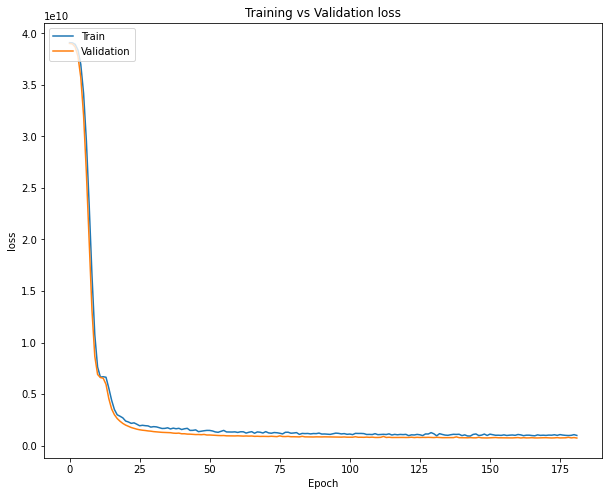

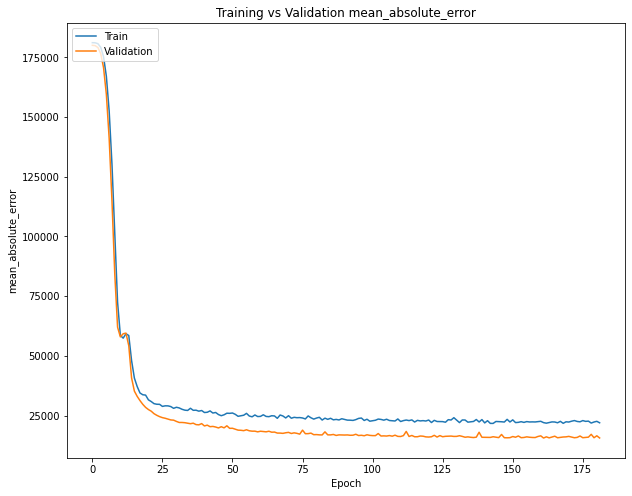

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 6

In [ ]:
# Parameters

epochs = 500
batch_size = 64
learningrate = 0.001
decay = 0.0
rho = 0.9
momentum = 0.0
nadam_b1 = 0.9
nadam_b2 = 0.999
epsilon = 1e-07

# Optimizer applied

opt_adam_2 = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)

def basic_model_6(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_2,
        metrics=[metrics.mae])
    return(t_model)

# Train MAE: 13,440
# Val   MAE: 15,906

# Early Stopping   : 60

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  13440.9658 , Train Loss:  426768864.0
Val Mean: 180034.4972
Val MAE:  15906.0371 , Val Loss:  710595520.0


## Plotting

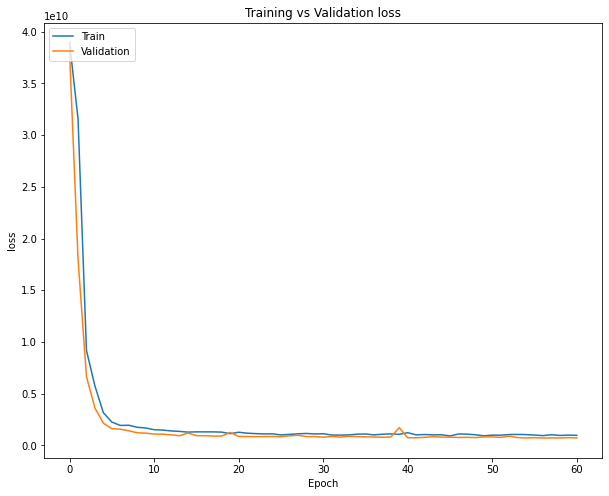

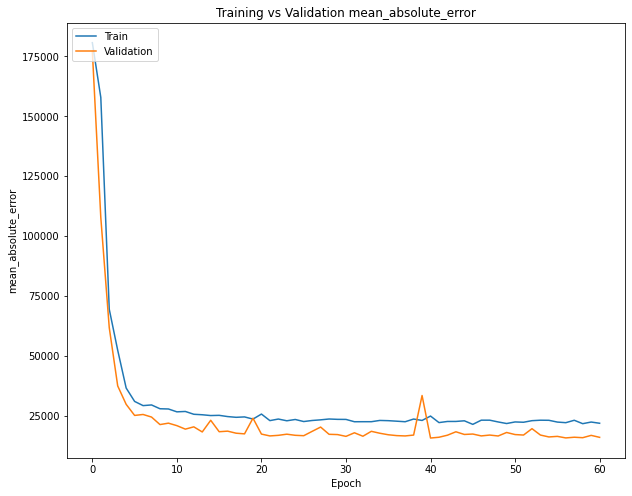

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 7

In [ ]:
# Parameters

epochs = 500
batch_size = 64
learningrate = 0.001
decay = 0.0
rho = 0.9
momentum = 0.0
nadam_b1 = 0.9
nadam_b2 = 0.999
epsilon = 1e-07

# Optimizer applied

opt_adadelta_1 = Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)

def basic_model_7(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adadelta_1,
        metrics=[metrics.mae])
    return(t_model)

# Train MAE: 15,795
# Val   MAE: 17,280

# Early Stopping   : 144

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  15794.9502 , Train Loss:  678631040.0
Val Mean: 180034.4972
Val MAE:  17280.0957 , Val Loss:  881945088.0


## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  25016.3496 , Train Loss:  981215680.0
Val Mean: 180034.4972
Val MAE:  26818.4844 , Val Loss:  1346014848.0


## Plotting

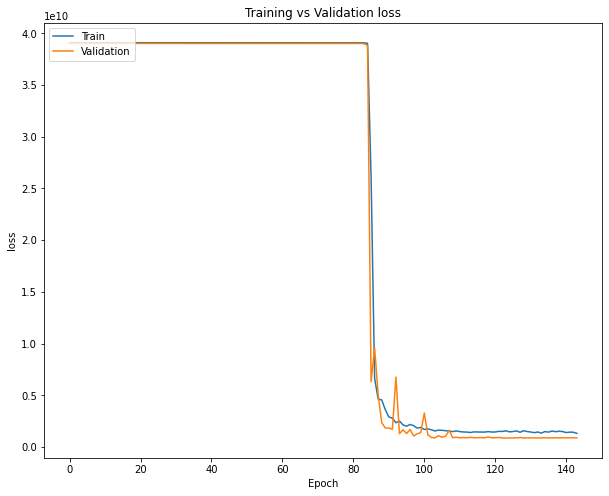

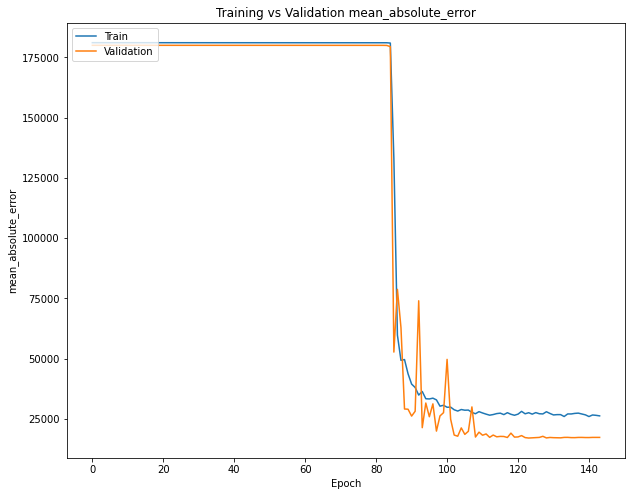

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 8

In [ ]:
# Parameters

epochs = 500 #500
batch_size = 128 #64
decay = 0.0
rho = 0.9
momentum = 0.5

# Optimizer applied

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
 
def basic_model_8(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(140, activation="tanh", kernel_initializer='glorot_normal', activity_regularizer=regularizers.l1_l2(0.05), input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(120, activation="tanh", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02), 
        activity_regularizer=regularizers.l1_l2(0.05)))
    t_model.add(Dropout(0.0))
  #  t_model.add(Dense(80, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
  #  t_model.add(Dropout(0.0))
    t_model.add(Dense(60, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='glorot_normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_1,
        metrics=[metrics.mae])
    return(t_model)


# Train MAE: 11,428
# Val   MAE: 15,104

# Early Stopping   : 233

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  11428.9932 , Train Loss:  322415232.0
Val Mean: 180034.4972
Val MAE:  15104.043 , Val Loss:  556828160.0


## Plotting

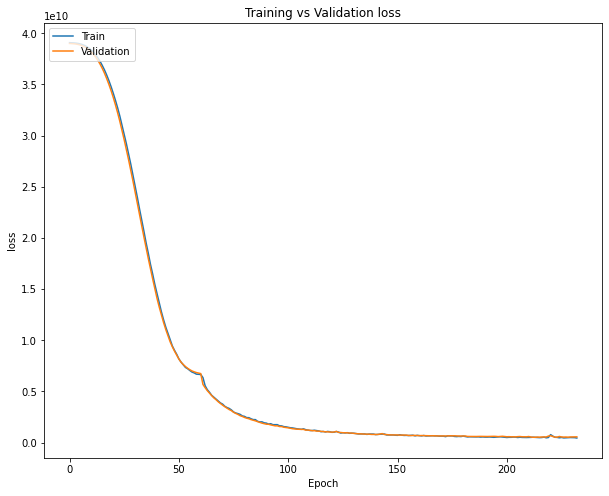

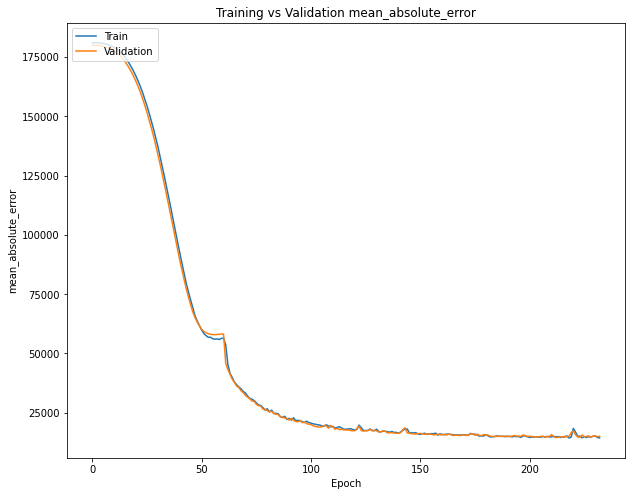

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 9


In [ ]:
# Parameters

epochs = 500 #500
batch_size = 128 #64
decay = 0.0
rho = 0.9
momentum = 0.5

# Optimizer applied

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
 
def basic_model_9(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(140, activation="tanh", kernel_initializer='glorot_normal', activity_regularizer=regularizers.l1_l2(0.05), input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(120, activation="tanh", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02), 
        activity_regularizer=regularizers.l1_l2(0.05)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(80, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(60, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='glorot_normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_1,
        metrics=[metrics.mae])
    return(t_model)


# Train MAE: 11,244
# Val   MAE: 14,731

# Early Stopping   : 102

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  11244.7734 , Train Loss:  270282048.0
Val Mean: 180034.4972
Val MAE:  14731.1709 , Val Loss:  544601984.0


## Plotting

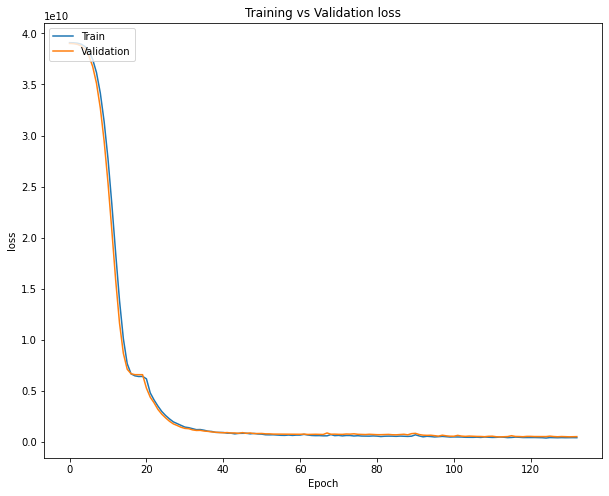

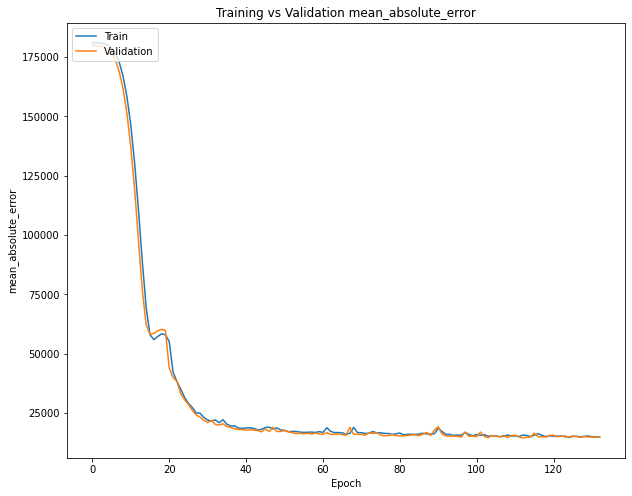

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 10

In [ ]:
# Parameters

epochs = 500 #500
batch_size = 128 #64
decay = 0.0
rho = 0.9
momentum = 0.5

# Optimizer applied

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
 
def basic_model_10(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='glorot_normal', activity_regularizer=regularizers.l1_l2(0.05), input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(140, activation="tanh", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02), 
        activity_regularizer=regularizers.l1_l2(0.05)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(100, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(60, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.05))
    t_model.add(Dense(40, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(20, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(10, activation="relu", kernel_initializer='glorot_normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_1,
        metrics=[metrics.mae])
    return(t_model)


# Train MAE: 12,373
# Val   MAE: 14,809

# Early Stopping   : 154

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  12373.3848 , Train Loss:  325475520.0
Val Mean: 180034.4972
Val MAE:  14809.5244 , Val Loss:  575434816.0


## Plotting

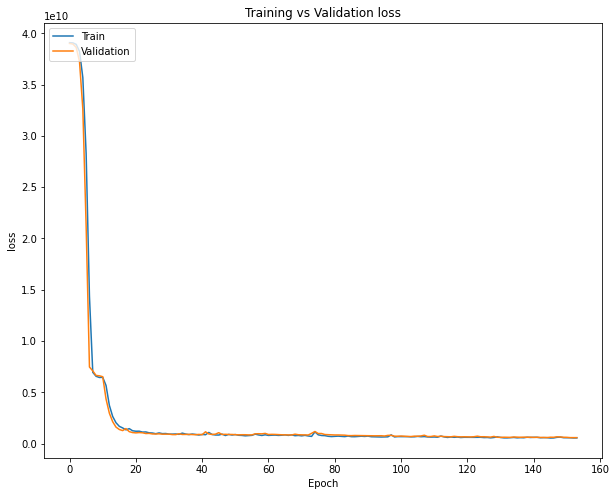

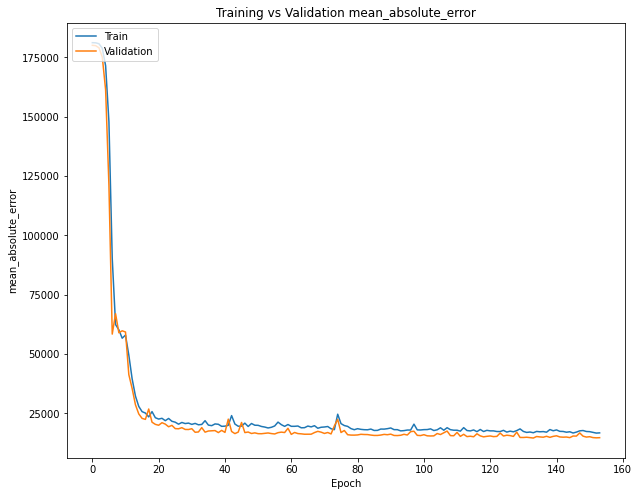

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Basic Model 11

In [ ]:
# Parameters

epochs = 500 #500
batch_size = 128 #64
decay = 0.0
rho = 0.9
momentum = 0.5

# Optimizer applied

opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
 
def basic_model_11(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(140, activation="tanh", kernel_initializer='glorot_normal', activity_regularizer=regularizers.l1_l2(0.05), input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(120, activation="tanh", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02), 
        activity_regularizer=regularizers.l1_l2(0.05)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(80, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(60, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='glorot_normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=opt_adam_1,
        metrics=[metrics.mae])
    return(t_model)


# Train MAE: 10,563
# Val   MAE: 14,534

# Early Stopping   : 201

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  10563.6094 , Train Loss:  228031840.0
Val Mean: 180034.4972
Val MAE:  14534.6924 , Val Loss:  505365344.0


## Plotting

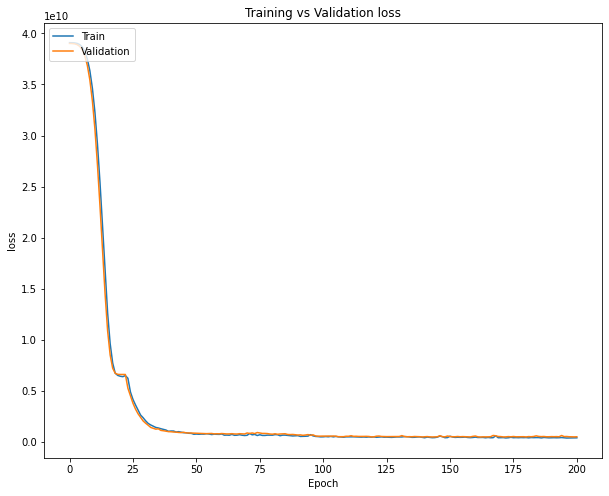

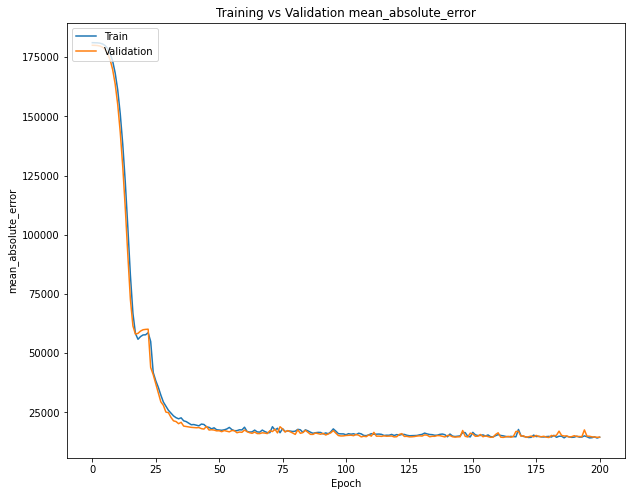

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  13169.9346 , Train Loss:  402512064.0
Val Mean: 180034.4972
Val MAE:  15354.8916 , Val Loss:  638365888.0


## Plotting

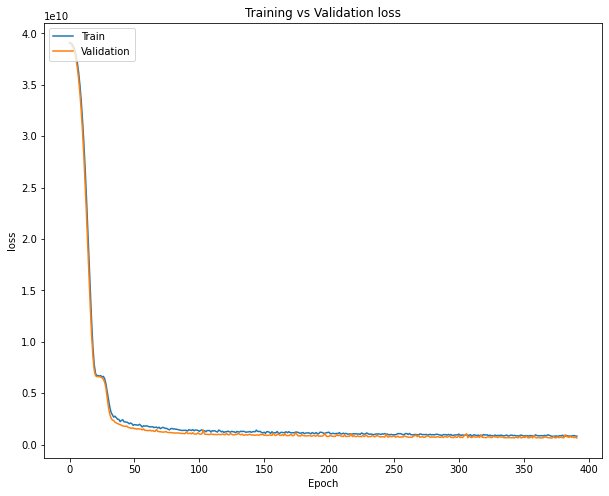

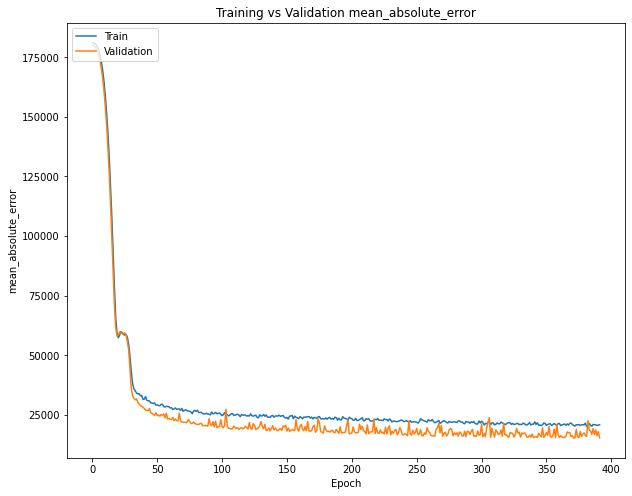

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

## Model Evaluation

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  13169.9346 , Train Loss:  402512064.0
Val Mean: 180034.4972
Val MAE:  15354.8916 , Val Loss:  638365888.0


## Plotting

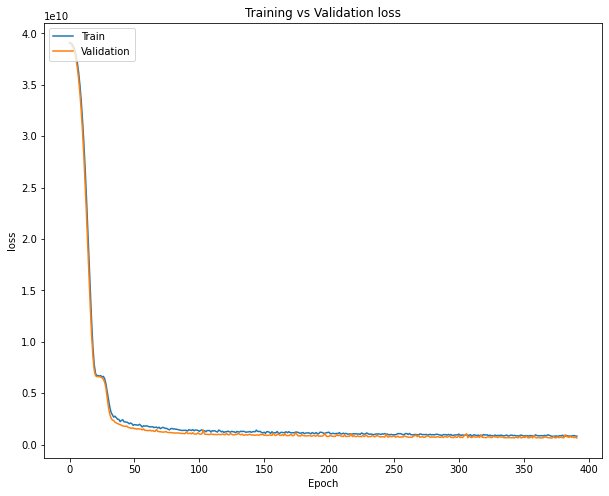

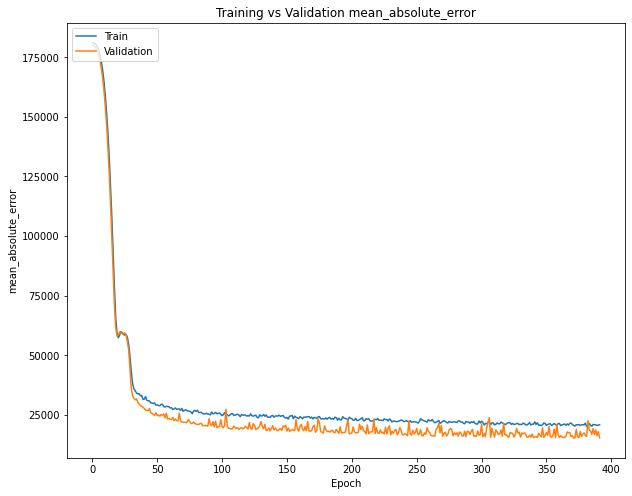

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

# Creating Model

*Now we create the executable model using one of the above functions.*

In [ ]:
model = basic_model_11(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 140)               14420     
_________________________________________________________________
dropout_238 (Dropout)        (None, 140)               0         
_________________________________________________________________
dense_285 (Dense)            (None, 120)               16920     
_________________________________________________________________
dropout_239 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_286 (Dense)            (None, 80)                9680      
_________________________________________________________________
dropout_240 (Dropout)        (None, 80)                0         
_________________________________________________________________
dense_287 (Dense)            (None, 60)              

## Fit/Train Keras model

*Fit the model and record the history of training and validation.*<br>
*As we specified EarlyStopping with patience=20, with luck the training will stop in less than 200 epochs.*

In [ ]:
# Specify which GPU to use on a multi-GPU system
# with tf.device('/gpu:1'):

# fix random seed for (near) reproducibility

# np.random.seed(7)

history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
17/17 - 0s - loss: 39087607808.0000 - mean_absolute_error: 181121.0938 - val_loss: 39015518208.0000 - val_mean_absolute_error: 180029.2031
Epoch 2/500
17/17 - 0s - loss: 39082704896.0000 - mean_absolute_error: 181107.5938 - val_loss: 39005097984.0000 - val_mean_absolute_error: 180000.2344
Epoch 3/500
17/17 - 0s - loss: 39064752128.0000 - mean_absolute_error: 181057.9844 - val_loss: 38974599168.0000 - val_mean_absolute_error: 179915.4375
Epoch 4/500
17/17 - 0s - loss: 39016116224.0000 - mean_absolute_error: 180924.2656 - val_loss: 38896439296.0000 - val_mean_absolute_error: 179698.0938
Epoch 5/500
17/17 - 0s - loss: 38901301248.0000 - mean_absolute_error: 180604.4844 - val_loss: 38725447680.0000 - val_mean_absolute_error: 179221.6562
Epoch 6/500
17/17 - 0s - loss: 38663864320.0000 - mean_absolute_error: 179949.2969 - val_loss: 38394978304.0000 - val_mean_absolute_error: 178297.3594
Epoch 7/500
17/17 - 0s - loss: 38227533824.0000 - mean_absolute_error: 178734.4531 - val_loss:

## Evaluate and report performance of the trained model

In [ ]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(ames_y_train['SalePrice'].mean(), 4))
print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Mean:', round(ames_y_valid['SalePrice'].mean(), 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Mean: 181122.4442
Train MAE:  10563.6094 , Train Loss:  228031840.0
Val Mean: 180034.4972
Val MAE:  14534.6924 , Val Loss:  505365344.0


*This function allows plotting of the training history*

*Now plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation. Note that the plot shows validation error as less than training error, which is quite deceptive. The reason for this is that training error is calculated for the entire epoch (and at its begining it was much worse than at the end), whereas the validation error is taken from the last batch (after the model improved). See the above evaluation statistics to confirm that the evaluation puts these errors in the correct order at the very end.*

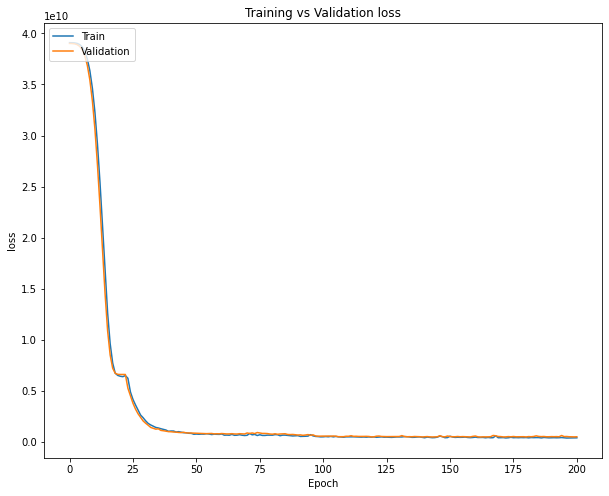

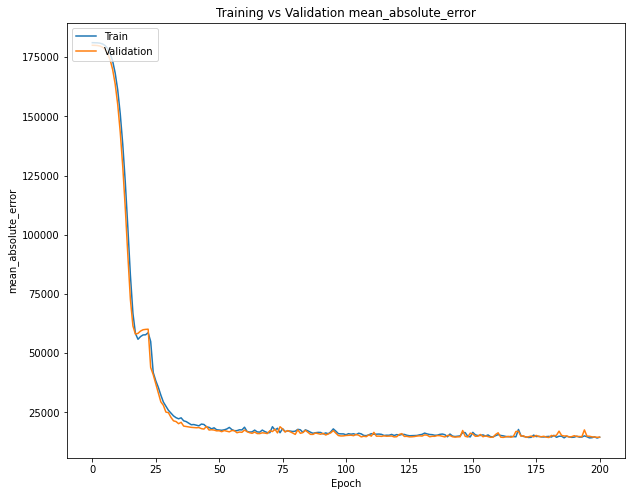

In [ ]:
hist = pd.DataFrame(history.history)

# Optionally save history to a CSV file
# hist.to_csv('../logs/model1-hist.csv')

# Plot history
plot_hist(hist, xsize=10, ysize=8)

<br>**All done! Your report follows.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

# MLP experiments, models and their results

## Analysis and recommendation

<font color="red">**Analysis**</font>

11 Experiments have been conducted to. build a price estimation model of Ames house real estate. We have used all the numerical variables and  a couple of Categorical Varibales in the intital Experiments. It was found that in some cases, more categorical varibales like Heating, Garage Style, Foundations etc, led to an improved results. Moroever, the last model generated was using 7 categorical varibales and was the best performing model. The model selected was basic_model_11 with a total of 5 layers and 3 hidden Layers, generating a Train MAE of 10,563 and Valid MAE of 14,534.

**Strengths**

1. Dropouts have been included which prevents the model from Overfitting.  

2. Adam optimizer have been used which helps in faster Convergance of the Model.

**Weakness**

A total of 5 Layers and 201 Epochs were used to generate the best results which if this model used on another dataset could be computationally expensive and Time Consuming.

**Recommendations**

basic_model_11 have been selected due to its low error rate. Also, the Training VS Validation loss Graph and Training VS Mean Absolute Error Graph shows less spikes in the overall run of the model which indicates that the model is learning well and is performing good on Validation Dataset. Also, the inclusion of Dropouts would help in preventing the Overfitting Problem.

## Summary of experimental results

<font color='red'>**Complete this table with the summary of your experimental results.**</font><br>
**Work in the order of tasks listed at top of this notebook. Example of table entry has been included.**

| Run# | Special Features / Changes | Train MAE | Valid MAE |
| :-: | :- | -: | -: |
| 1 | Vars: Numeric + Neighbourhood + House_Style, two hidden layers (100, 50), tanh on first, the rest are relu activations, no dropouts or regularisation, RMSprop optimiser, early stop at 260 | 56,615 | 59,366 |
| 2 | Vars: Numeric + Neighbourhood + House_Style, three hidden layers (100, 180, 20), tanh on first, the rest are relu activations, dropouts = 0.2 ,no regularisation, RMSprop optimiser, early stop at 272 | 16,633 | 18,560 |
| 3 | Vars: Numeric + Neighbourhood + House_Style, Four hidden layers (80, 120, 20, 10), tanh on first, the rest are relu activations, dropouts(0.2, 0.1, 0.1, 0.0) , yes regularisation, Nadam optimiser, early stop at 272 | 13,548 | 15,657 |
|#4 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating, Four hidden layers (80, 120, 20, 10), tanh on first, the rest are relu activations, dropouts(0.2, 0.1, 0.1, 0.0) , yes regularisation, Nadam optimiser(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07), early stop at 390 | 13,170 | 15,354 |
|#5 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating, Four hidden layers (80, 120, 20, 10), tanh on first, the rest are relu activations, dropouts(0.2, 0.1, 0.1, 0.0) , yes regularisation, Adam optimiser(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), early stop at 179 | 13,638 | 15,661 |
|#6 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating, Four hidden layers (80, 120, 20, 10), tanh on first, the rest are relu activations, dropouts(0.2, 0.1, 0.1, 0.0) , yes regularisation, Adam optimiser(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07), early stop at 60 | 13,440 | 15,906 |
|#7 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating, Four hidden layers (80, 120, 20, 10), tanh on first, the rest are relu activations, dropouts(0.2, 0.1, 0.1, 0.0) , yes regularisation, Adadelta optimizer(lr=0.001, rho=0.95, epsilon=1e-07), early stop at 144 | 15,795 | 17,280 |
|#8 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating + Garage_Type _ Kitchen_Qual, Four hidden layers (140, 120, 60, 20), tanh on first and second, the rest are relu activations, dropouts(0.1, 0.0, 0.0, 0.0) , yes regularisation, Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), early stop at 233 | 11,428 | 15,104 |
|#9 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating + Garage_Type _ Kitchen_Qual, Four hidden layers (140, 120, 80, 60, 20), tanh on first and second, the rest are relu activations, dropouts(0.1, 0.0, 0.0, 0.1, 0.0) , yes regularisation, Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), early stop at 102 | 11,224 | 14,731 |
|#10 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating + Garage_Type _ Kitchen_Qual, Seven hidden layers (80, 140, 100, 60, ,40, 20, 10), tanh on first and second, the rest are relu activations, dropouts(0.1, 0.1, 0.1, 0.05, 0.0, 0.0, 0.0) , yes regularisation, Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), early stop at 154 | 12,373 | 14,809 |
|#11 | Vars: Numeric + Neighbourhood + House_Style + Roof_style + Heating + Garage_Type + Kitchen_Qual + Foundation, Five hidden layers (140, 120, 80, 60, ,20), tanh on first and second, the rest are relu activations, dropouts(0.1, 0.0, 0.0 0.1, 0.0) , yes regularisation, Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), early stop at 201 | 10,563 | 14,534 |
<br>